In [49]:
%pip install pandas scikit-learn matplotlib seaborn joblib


Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import joblib


In [51]:
# Load dataset (no headers in file, so set header=None)
df = pd.read_csv(
    "vm_metrics.csv",
    header=None,
    names=["timestamp", "vm", "host", "cpu", "memory", "network_io", "power"]
)

print(df.head())
print(df.info())


            timestamp   vm   host  cpu  memory           network_io  power
0           timestamp   vm   host  cpu  memory           network_io  power
1   1758733864.359414  VM1  Host3   90      24   3.1456437095765586    111
2  1758733864.3594189  VM2  Host1   14       3    2.600845587959168    255
3   1758733864.359423  VM3  Host3   29      27  0.42172879154869947    231
4   1758733864.359425  VM4  Host3   73      31    1.069542877909903    215
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   timestamp   1000001 non-null  object
 1   vm          1000001 non-null  object
 2   host        1000001 non-null  object
 3   cpu         1000001 non-null  object
 4   memory      1000001 non-null  object
 5   network_io  1000001 non-null  object
 6   power       1000001 non-null  object
dtypes: object(7)
memory usage: 53.4+ MB
None


/var/folders/h2/wm9znrpn1t91bqtr9g3njc7h0000gn/T/ipykernel_92987/1263842556.py:2: DtypeWarning: Columns (0,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [52]:
import pandas as pd

# Load CSV, skip the first bad row
df = pd.read_csv("vm_metrics.csv", skiprows=[1])

print(df.head())
print(df.dtypes)


      timestamp   vm   host  cpu  memory  network_io  power
0  1.758734e+09  VM2  Host1   14       3    2.600846    255
1  1.758734e+09  VM3  Host3   29      27    0.421729    231
2  1.758734e+09  VM4  Host3   73      31    1.069543    215
3  1.758734e+09  VM5  Host2   38      17    2.417838    121
4  1.758734e+09  VM6  Host1   23       1    4.647009    296
timestamp     float64
vm             object
host           object
cpu             int64
memory          int64
network_io    float64
power           int64
dtype: object


In [53]:
# Convert numeric columns
df["cpu"] = pd.to_numeric(df["cpu"])
df["memory"] = pd.to_numeric(df["memory"])
df["network_io"] = pd.to_numeric(df["network_io"])
df["power"] = pd.to_numeric(df["power"])


In [54]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Only drop timestamp if it exists
if "timestamp" in df.columns:
    df = df.drop(columns=["timestamp"])

# Encode categorical column 'vm'
le_vm = LabelEncoder()
df["vm"] = le_vm.fit_transform(df["vm"])

# Features (X) and Target (y)
X = df.drop(columns=["host"])   # everything except host
y = df["host"]                  # predict host

# Feature engineering
X["cpu_mem_ratio"] = X["cpu"] / X["memory"]
X["power_per_cpu"] = X["power"] / X["cpu"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features shape:", X_scaled.shape)
print("Target shape:", y.shape)
print("Feature columns:", X.columns)


Features shape: (999999, 7)
Target shape: (999999,)
Feature columns: Index(['vm', 'cpu', 'memory', 'network_io', 'power', 'cpu_mem_ratio',
       'power_per_cpu'],
      dtype='object')


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 799999
Testing samples: 200000


In [64]:
from sklearn.preprocessing import LabelEncoder

# Encode host labels
le_host = LabelEncoder()
y_train_encoded = le_host.fit_transform(y_train)  # now y_train_encoded has 0,1,2

# Optional: save the encoder for later
import joblib
joblib.dump(le_host, "label_encoder_host.pkl")


['label_encoder_host.pkl']

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=12,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42
)

# Train on integer-encoded labels
random_search.fit(X_train, y_train_encoded)

model = random_search.best_estimator_

# Save model
joblib.dump(model, "rfinal_vm_host_placement_model.pkl")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   7.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   7.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   7.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.6s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   9.7s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   9.8s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  10.0s
[CV] END max_depth=10, min_samples_l

['rfinal_vm_host_placement_model.pkl']

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00

Classification Report:
               precision    recall  f1-score   support

       Host1       1.00      1.00      1.00     20394
       Host2       1.00      1.00      1.00     76453
       Host3       1.00      1.00      1.00    103153

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



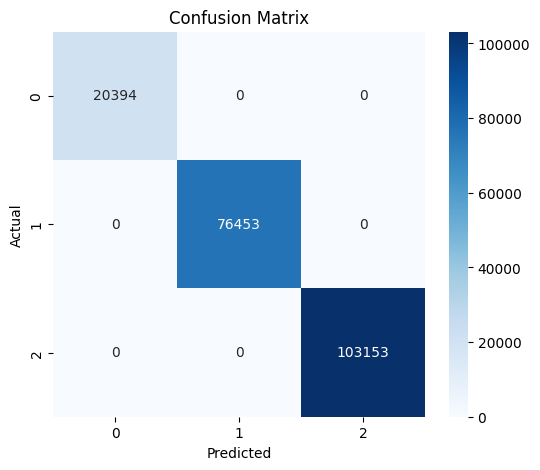

In [71]:
# y_test and y_pred are already strings
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted")
rec = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-score: {f1:.2f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [70]:
y_pred_encoded = model.predict(X_test)
print(type(y_pred_encoded[0]), y_pred_encoded[:5])


<class 'str'> ['Host3' 'Host3' 'Host2' 'Host1' 'Host2']
